In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]

pathPre = '/media/robert/Data_Storage/VSim/Matched-Accelerating-Gradient/3DConvergence_Tests/'
simName = 'AccelGradient'

{'time': {0: 0.0, 1: 1.5262597023039975e-13, 2: 3.0525194046079924e-13, 3: 4.5787791069119871e-13, 4: 6.1050388092159818e-13, 5: 7.6312985115199765e-13, 6: 9.1575582138239722e-13}, 'bounds': {0: array([ -5.00000000e-05,   5.00000000e-05,  -5.00000000e-05,
         5.00000000e-05]), 1: array([ -5.00000000e-06,   9.50000000e-05,  -5.00000000e-05,
         5.00000000e-05]), 2: array([  4.10000000e-05,   1.41000000e-04,  -5.00000000e-05,
         5.00000000e-05]), 3: array([  8.70000000e-05,   1.87000000e-04,  -5.00000000e-05,
         5.00000000e-05]), 4: array([  1.33000000e-04,   2.33000000e-04,  -5.00000000e-05,
         5.00000000e-05]), 5: array([  1.78000000e-04,   2.78000000e-04,  -5.00000000e-05,
         5.00000000e-05]), 6: array([  2.24000000e-04,   3.24000000e-04,  -5.00000000e-05,
         5.00000000e-05])}}


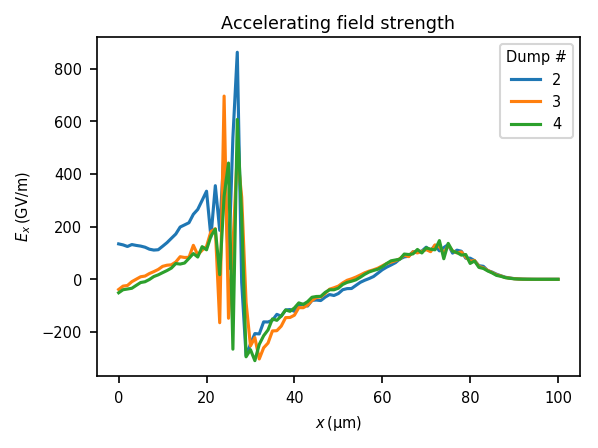

In [2]:
# Lets plot the electric field along axis and see how well it is converged
path = pathPre + '1e18PlasmaDensity/GridConvergence/0.5umX0.5umX1um/'
Efield, Eattrs = load.load_field(path, simName, 'edgeE')
Nx, Ny, Nz = analyze.get_shape(Efield[2])
x = np.linspace(0, 100, Nx)
print(Eattrs)

plt.figure(figsize=(4,3), dpi=150)
gs = gridspec.GridSpec(1, 1)
plt.subplot(gs[0, 0])
plt.plot(x, Efield[2][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.plot(x, Efield[3][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.plot(x, Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.title('Accelerating field strength')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['2', '3', '4'], title='Dump #')
plt.tight_layout()
plt.show()

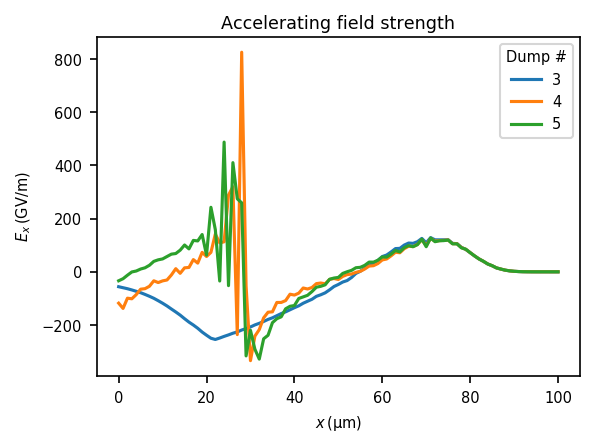

In [3]:
# Same thing for the shorter propagation distance
path = pathPre + '1e18PlasmaDensity/GridConvergence/0.75umX0.75umX1um/'
Efield, Eattrs = load.load_field(path, simName, 'edgeE')
Nx, Ny, Nz = analyze.get_shape(Efield[2])
x = np.linspace(0, 100, Nx)

plt.figure(figsize=(4,3), dpi=150)
gs = gridspec.GridSpec(1, 1)
plt.subplot(gs[0, 0])
plt.plot(x, Efield[3][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.plot(x, Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.plot(x, Efield[5][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9)
plt.title('Accelerating field strength')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['3', '4', '5'], title='Dump #')
plt.tight_layout()
plt.show()
#First dump isn't really useful but the two later dumps are

[a, x_0, Ed] [  8.80899486e-02   7.22658911e+01   9.80535531e+01]
[a, x_0, Ed] [  8.96447816e-02   7.08608917e+01   1.10332298e+02]
[a, x_0, Ed] [  8.67333654e-02   7.09966136e+01   1.03111538e+02]
[a, x_0, Ed] [  8.81150619e-02   7.13835725e+01   1.03685678e+02]


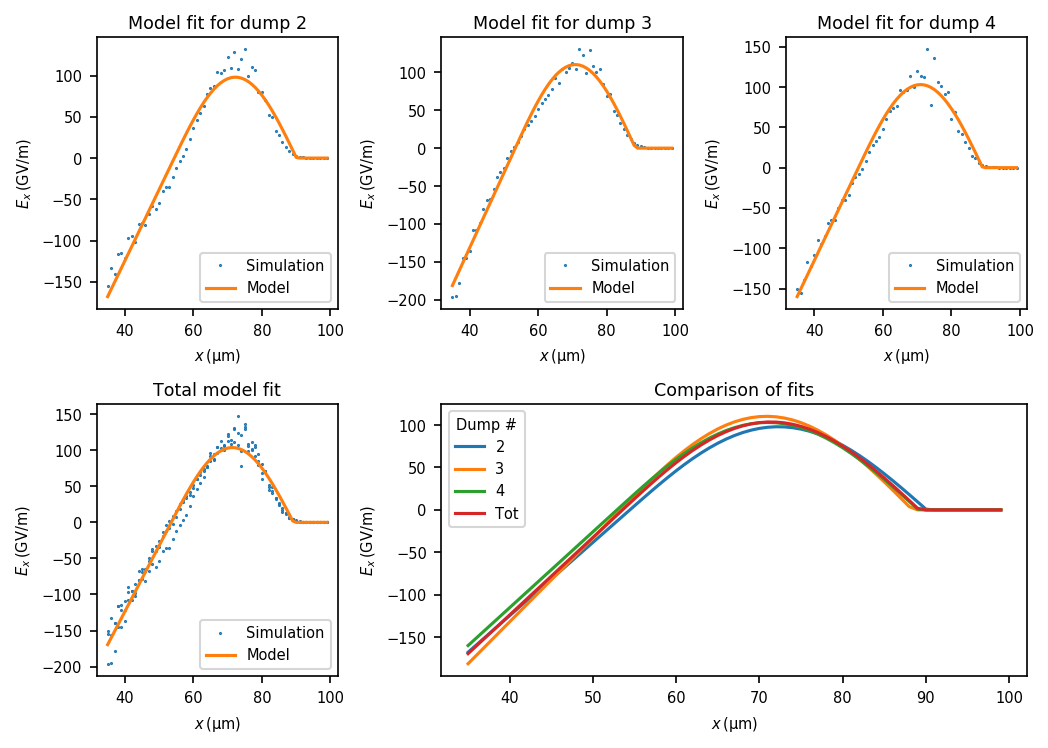

In [4]:
# Next we want to fit a curve to these and see what the accelerating gradient is
path = pathPre + '1e18PlasmaDensity/GridConvergence/0.5umX0.5umX1um/'
Efield, Eattrs = load.load_field(path, simName, 'edgeE')
Nx, Ny, Nz = analyze.get_shape(Efield[2])
x = np.linspace(0, 100, Nx)
lim = [35, 100]
E2 = Efield[2][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
E3 = Efield[3][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
E4 = Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
x = x[lim[0]:lim[1]]

def sineline(x, a, x_0, Ed):
    x = np.array(x)
    out = np.empty(len(x))
    # Sin part
    sel = np.logical_and(x > (x_0-np.pi/(2*a)), x < (x_0+np.pi/(2*a)))
    out[sel] = Ed*np.cos(a*(x[sel]-x_0))
    # Line part
    sel = x <= (x_0-np.pi/(2*a))
    out[sel] = Ed*a*x[sel] + (np.pi/(2*a)-x_0)*Ed*a
    # Zeros
    sel = x >= (x_0+np.pi/(2*a))
    out[sel] = 0.0
    return out

plt.figure(figsize=(7,5), dpi=150)
gs = gridspec.GridSpec(2, 6)

popt2, pcov = curve_fit(sineline, x, E2, p0=[0.1, 70, 200])
print('[a, x_0, Ed]', popt2)
plt.subplot(gs[0, 0:2])
plt.plot(x, E2, marker='o', linestyle='None', markersize=0.5)
plt.plot(x, sineline(x, *popt2))
plt.title('Model fit for dump 2')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['Simulation', 'Model'])

popt3, pcov = curve_fit(sineline, x, E3, p0=[0.1, 70, 200])
print('[a, x_0, Ed]', popt3)
plt.subplot(gs[0, 2:4])
plt.plot(x, E3, marker='o', linestyle='None', markersize=0.5)
plt.plot(x, sineline(x, *popt3))
plt.title('Model fit for dump 3')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['Simulation', 'Model'])

popt4, pcov = curve_fit(sineline, x, E4, p0=[0.1, 70, 200])
print('[a, x_0, Ed]', popt4)
plt.subplot(gs[0, 4:6])
plt.plot(x, E4, marker='o', linestyle='None', markersize=0.5)
plt.plot(x, sineline(x, *popt4))
plt.title('Model fit for dump 4')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['Simulation', 'Model'])

EA = np.concatenate([E2, E3, E4])
xA = np.concatenate([x, x, x])
poptA, pcov = curve_fit(sineline, xA, EA, p0=[0.1, 70, 200])
print('[a, x_0, Ed]', poptA)
plt.subplot(gs[1, 0:2])
plt.plot(xA, EA, marker='o', linestyle='None', markersize=0.5)
plt.plot(x, sineline(x, *poptA))
plt.title('Total model fit')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['Simulation', 'Model'])

plt.subplot(gs[1, 2:6])
plt.plot(x, sineline(x, *popt2))
plt.plot(x, sineline(x, *popt3))
plt.plot(x, sineline(x, *popt4))
plt.plot(x, sineline(x, *poptA))
plt.title('Comparison of fits')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['2', '3', '4', 'Tot'], title='Dump #')
plt.tight_layout()
plt.show()
# The model fits all three curves fairly well, the total model looks like the average of the others

[a, x_0, Ed] [  8.59249012e-02   7.11689575e+01   1.02054426e+02]


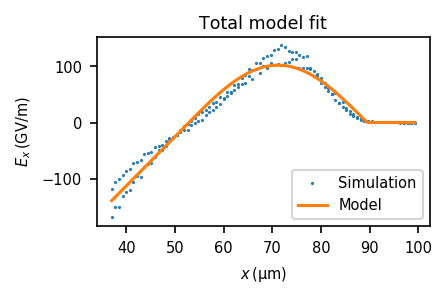

In [5]:
# Lets look at all the other convergence simulations
path = pathPre + '1e18PlasmaDensity/GridConvergence/1umX1umX0.75um/'
Efield, Eattrs = load.load_field(path, simName, 'edgeE')
Nx, Ny, Nz = analyze.get_shape(Efield[2])
x = np.linspace(0, 100, Nx)
lim = [50, 135]
E4 = Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
E5 = Efield[5][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
x = x[lim[0]:lim[1]]

plt.figure(figsize=(3,2), dpi=150)
gs = gridspec.GridSpec(1, 1)
EA = np.concatenate([E4, E5])
xA = np.concatenate([x, x])
poptA, pcov = curve_fit(sineline, xA, EA, p0=[0.1, 70, 100], maxfev=10000)
print('[a, x_0, Ed]', poptA)
plt.subplot(gs[0, 0])
plt.plot(xA, EA, marker='o', linestyle='None', markersize=0.5)
plt.plot(x, sineline(x, *poptA))
plt.title('Total model fit')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['Simulation', 'Model'])
plt.tight_layout()
plt.show()
# This is going to be ridiculous to do this for all of the convergence studies

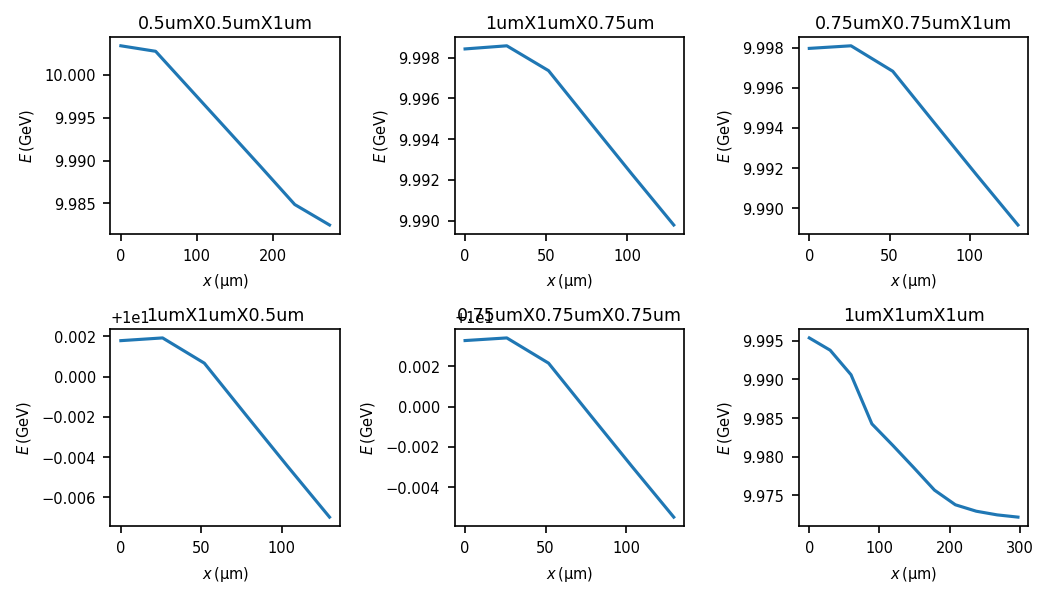

In [6]:
# A better parameter to look at might be the drive beam energy and see how it is being decelerated
pathPre2 = '1e18PlasmaDensity/GridConvergence/'
species = 'ElectronBeam'
sims = [
    '0.5umX0.5umX1um',
    '0.75umX0.75umX0.75um',
    '0.75umX0.75umX1um',
    '1umX1umX0.5um',
    '1umX1umX0.75um',
    '1umX1umX1um'
]
dumps = [6, 5, 5, 5, 5, 10]
plt.figure(figsize=(7,4), dpi=150)
gs = gridspec.GridSpec(2, 3)
for i in range(len(sims)):
    path = pathPre + pathPre2 +sims[i] +'/'
    energy = np.zeros(dumps[i]+1, dtype='double')
    x = np.zeros(dumps[i]+1, dtype='double')
    for j in range(dumps[i]+1):
        file = plot.get_filename(path, simName, species, j)
        data = load.get_species_data(file, species)
        attrs = load.get_species_attrs(file, species)
        energy[j] = analyze.get_energy(data, me*1e-3)
        x[j] = c*attrs['time']
    plt.subplot(gs[i % 2, i % 3])
    plt.plot(x*1e6, energy)
    plt.title(sims[i])
    plt.xlabel(r'$x\,(\mathrm{\mu m})$')
    plt.ylabel(r'$E\,(\mathrm{GeV})$')
plt.tight_layout()
plt.show()

[-97.63534555 -98.38879511 -98.08581434 -98.42682029 -98.0095228
 -94.91157834]


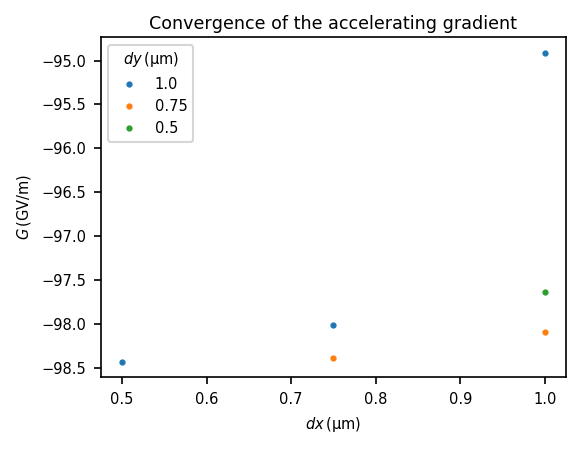

In [14]:
# Now grab the linear sections and use them to find the accelerating gradient
start = [1, 2, 2, 2 ,2, 3]
end = [5, 5, 5 ,5, 5, 5]
gradient = np.zeros(len(sims))
for i in range(len(sims)):
    path = pathPre + pathPre2 +sims[i] +'/'
    energy = np.zeros(dumps[i]+1, dtype='double')
    x = np.zeros(dumps[i]+1, dtype='double')
    for j in range(dumps[i]+1):
        file = plot.get_filename(path, simName, species, j)
        data = load.get_species_data(file, species)
        attrs = load.get_species_attrs(file, species)
        energy[j] = analyze.get_energy(data, me*1e-3)
        x[j] = c*attrs['time']
    gradient[i] = (energy[end[i]] - energy[start[i]]) / (x[end[i]] - x[start[i]])
print(gradient)
plt.figure(figsize=(4,3), dpi=150)
plt.plot([0.5, 0.75, 1.0], [gradient[3], gradient[4], gradient[5]],  marker='o', linestyle='None',
         markersize=2)
plt.plot([0.75, 1.0], [gradient[1], gradient[2]],  marker='o', linestyle='None', markersize=2)
plt.plot([1.0], [gradient[0]],  marker='o', linestyle='None', markersize=2)
plt.title('Convergence of the accelerating gradient')
plt.xlabel(r'$dx\,(\mathrm{\mu m})$')
plt.ylabel(r'$G\,(\mathrm{GV/m})$')
plt.legend(['1.0', '0.75', '0.5'], title=r'$dy\,(\mathrm{\mu m})$')
plt.show()
# Luckily, it looks like the simulation is converging quadratically